In [ ]:
!pip install torchview

In [ ]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import torch.nn.functional as functional
import numpy as np
import os
import graphviz
from torchview import draw_graph
from matplotlib import pyplot as plt

## **1. Загрузка и обработка данных**

Выполним предобработку тренировочных данных:

1. нормализация по каналам
2. случайный горизонтальный переворот
3. обрезка изображения в случайном месте с дополнениям по всем границам

In [ ]:
dir_name = os.getcwd()
norm_params = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
batch_size = 128

# Загрузка тренировочного набора данных CIFAR-10 без применения нормализации
train_dataset_raw = torchvision.datasets.CIFAR10(
    root=dir_name, train=True, download=True,
    transform=torchvision.transforms.ToTensor()
)

# Вычисление среднего значения и стандартного отклонения для каждого канала цвета
mean = np.mean(train_dataset_raw.data / 255, axis=(0, 1, 2))
std = np.std(train_dataset_raw.data / 255, axis=(0, 1, 2))
# Параметры нормализации для каждого канала цвета
norm_params = (mean, std)

# Случайное обрезание изображения размером 32x32 с отступом 4 пикселя и отражением границы
# Случайное горизонтальное отражение изображения
# Нормализация

transform_train = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*norm_params, inplace=True)
    ]
)

transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*norm_params)
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = transforms
)

100%|██████████| 170498071/170498071 [00:01<00:00, 99249914.08it/s] 


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f'Classes of dataset: {classes}')

Classes of dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Number of train samples: 50000
Number of test samples: 10000


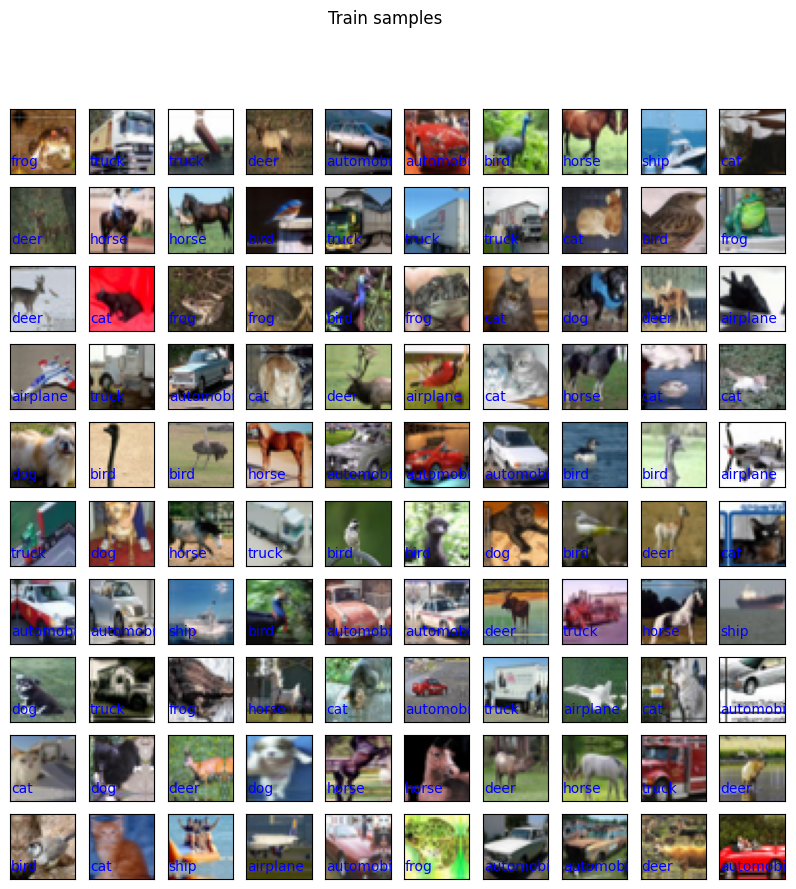

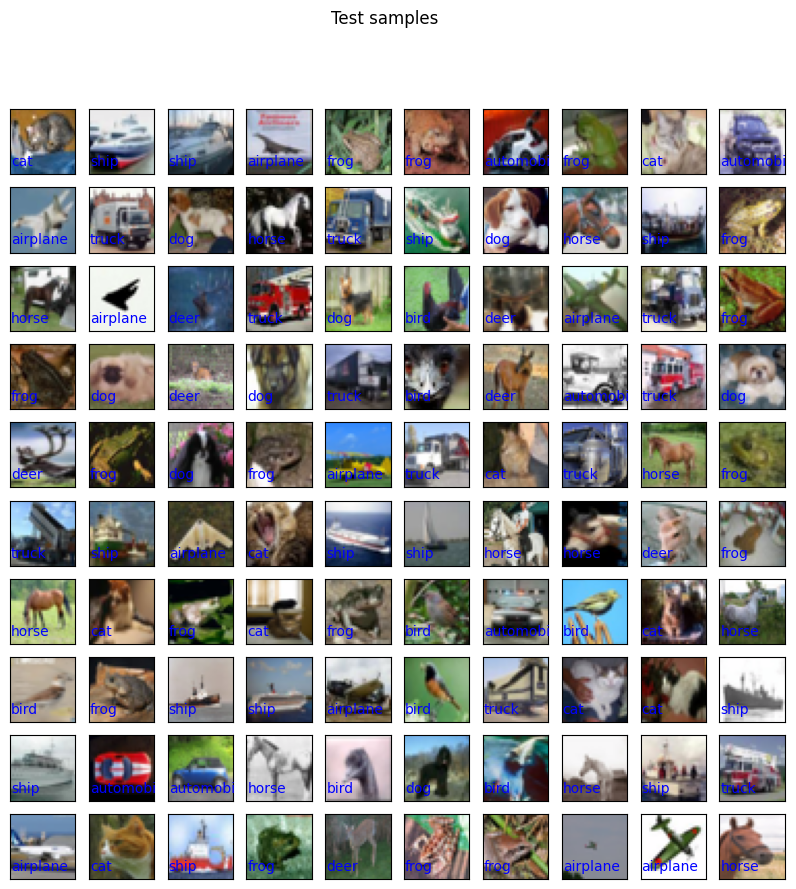

In [ ]:
def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plt.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        original_img = images[i][0] * torch.tensor(std).reshape(3, 1, 1) + torch.tensor(mean).reshape(3, 1, 1)
        img = original_img.numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))
        ax.text(0, 27, str(classes[images[i][1]][:8]), color = 'b')

print(f'Number of train samples: {len(train_dataset)}')
show_images(train_dataset, 'Train samples')

print(f'Number of test samples: {len(test_dataset)}')
show_images(test_dataset, 'Test samples')

In [ ]:
def get_shape_input(dataset):
  n = len(dataset)
  c, h, w = dataset[0][0].numpy().shape
  return [n, *(dataset[0][0].numpy().shape)]

print(f'Shape of input train data: {get_shape_input(train_dataset)}')
print(f'Shape of input test data: {get_shape_input(test_dataset)}')
print(f'Data type: {train_dataset[0][0].numpy().dtype}')

Shape of input train data: [50000, 3, 32, 32]
Shape of input test data: [10000, 3, 32, 32]
Data type: float32


In [ ]:
def get_shape_output(dataset):
  N = len(dataset)
  return '({}, 1)'.format(N)

print(f'Shape of output train data: {get_shape_output(train_dataset)}')
print(f'Shape of output test data: {get_shape_output(test_dataset)}')


Shape of output train data: (50000, 1)
Shape of output test data: (10000, 1)


## **2. Построение архитектуры сверточной сети**

In [ ]:
class Block(torch.nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.conv3 = torch.nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = torch.nn.BatchNorm2d(out_planes)

        self.shortcut = torch.nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                torch.nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = functional.relu(self.bn1(self.conv1(x)))
        out = functional.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


class MobileNetV2(torch.nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  # NOTE: change stride 2 -> 1 for CIFAR10
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        # NOTE: change conv1 stride 2 -> 1 for CIFAR10
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = torch.nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(1280)
        self.linear = torch.nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = functional.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = functional.relu(self.bn2(self.conv2(out)))
        # NOTE: change pooling kernel_size 7 -> 4 for CIFAR10
        out = functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


## MobileNetV2

In [ ]:
mobileNet = MobileNetV2()
mobileNet

MobileNetV2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
     

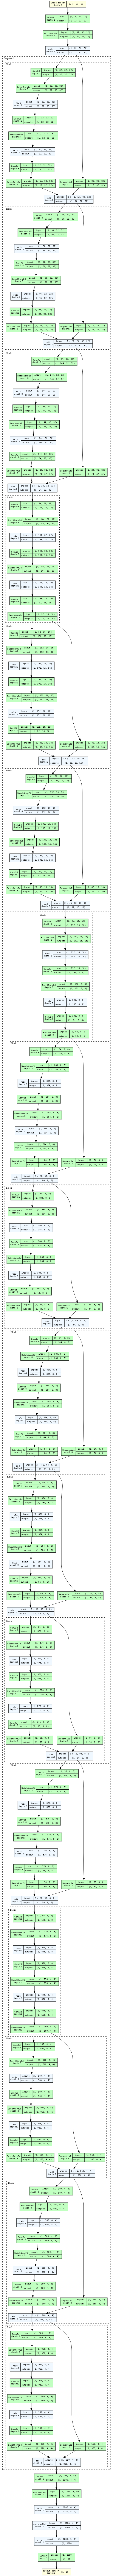

In [ ]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(mobileNet, input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

In [ ]:
learning_rate = 0.001
num_epochs = 40

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobileNet.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobileNet.parameters(), lr = learning_rate)
device

device(type='cuda', index=0)

In [ ]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def epoch_acc(accuracies):
  return torch.stack(accuracies).mean()

def epoch_loss(losses):
  return torch.stack(losses).mean()

In [ ]:
import time
def train(cnn_model, data_loader, epochs, loss_function, optimizer, device):
  start_time = time.time()
  for epoch in range(epochs):
    start_epoch = time.time()
    accuracies = []
    losses = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)
        acc = accuracy(outputs, labels)

        losses.append(loss)
        accuracies.append(acc)

        loss.backward()
        optimizer.step()
    total_time_epoch = time.time() - start_epoch
    print('Epoch[{}]: Loss = {:.4f}, Train accuracy = {:.4f}, Time epoch = {:.4f}'.
          format(epoch + 1,
                 epoch_loss(losses),
                 epoch_acc(accuracies),
                 total_time_epoch))
  total_time = time.time() - start_time
  print('Total time {}'.format(total_time))

In [ ]:
train(mobileNet, train_data_loader, num_epochs, loss_function, optimizer, device)

Epoch[1]: Loss = 1.4744, Train accuracy = 0.4593, Time epoch = 51.2367
Epoch[2]: Loss = 1.0454, Train accuracy = 0.6277, Time epoch = 51.2263
Epoch[3]: Loss = 0.8375, Train accuracy = 0.7058, Time epoch = 50.3920
Epoch[4]: Loss = 0.7250, Train accuracy = 0.7456, Time epoch = 51.2032
Epoch[5]: Loss = 0.6455, Train accuracy = 0.7735, Time epoch = 54.0805
Epoch[6]: Loss = 0.5873, Train accuracy = 0.7962, Time epoch = 51.9758
Epoch[7]: Loss = 0.5422, Train accuracy = 0.8131, Time epoch = 50.8537
Epoch[8]: Loss = 0.5095, Train accuracy = 0.8222, Time epoch = 49.9630
Epoch[9]: Loss = 0.4755, Train accuracy = 0.8344, Time epoch = 50.7680
Epoch[10]: Loss = 0.4505, Train accuracy = 0.8420, Time epoch = 50.4333
Epoch[11]: Loss = 0.4266, Train accuracy = 0.8524, Time epoch = 50.9233
Epoch[12]: Loss = 0.3985, Train accuracy = 0.8636, Time epoch = 50.1917
Epoch[13]: Loss = 0.3901, Train accuracy = 0.8655, Time epoch = 50.2850
Epoch[14]: Loss = 0.3691, Train accuracy = 0.8725, Time epoch = 50.3586
E

In [ ]:
print('Loss = {:.4f}, Test accuracy = {:.4f}'.format(
    get_loss(mobileNet, test_data_loader, device),
    get_accuracy(mobileNet, test_data_loader, device)))

Loss = 0.0184, Test accuracy = 0.0939


## ResNet9

In [ ]:
def blocks(in_channels, out_channels):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace=True)
    )

In [ ]:
class ResNet9(torch.nn.Module):
  def __init__(self):
      super(ResNet9, self).__init__()
      self.conv1 = blocks(3, 64)
      self.conv_and_pool_1 = torch.nn.Sequential(
          blocks(64, 128),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.res1 = torch.nn.Sequential(
          blocks(128, 128),
          blocks(128, 128)
      )
      self.conv_and_pool_2 = torch.nn.Sequential(
          blocks(128, 256),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.conv_and_pool_3 = torch.nn.Sequential(
          blocks(256, 512),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.res2 = torch.nn.Sequential(
          blocks(512, 512),
          blocks(512, 512)
      )
      self.final_pool = torch.nn.MaxPool2d(kernel_size=4)
      self.dense = torch.nn.Sequential(
          torch.nn.Flatten(),
          torch.nn.Dropout(0.2),
          torch.nn.Linear(512, 10)
      )

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv_and_pool_1(out)
    out = self.res1(out) + out
    out = self.conv_and_pool_2(out)
    out = self.conv_and_pool_3(out)
    out = self.res2(out) + out
    out = self.final_pool(out)
    out = self.dense(out)
    return out

In [ ]:
resNet = ResNet9()
resNet

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_and_pool_1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_run

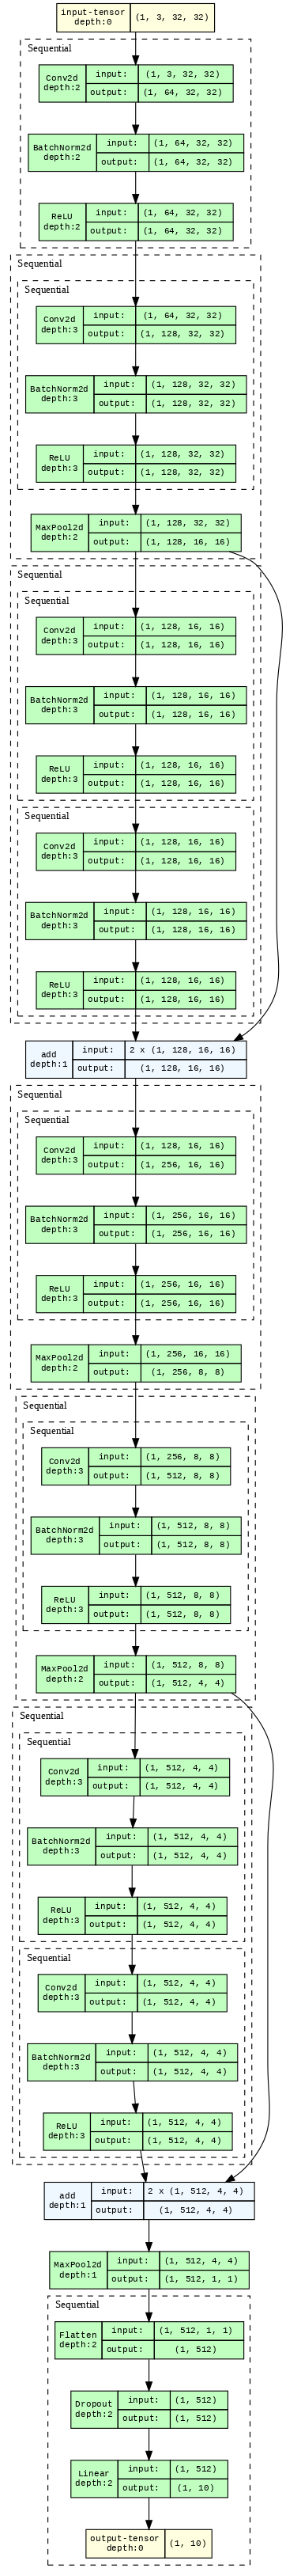

In [ ]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(resNet, input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

In [ ]:
resNet.to(device)
optimizer = torch.optim.Adam(resNet.parameters(), lr = learning_rate)

In [ ]:
train(resNet, train_data_loader, num_epochs, loss_function, optimizer, device)

Epoch[1]: Loss = 1.3777, Train accuracy = 0.5131, Time epoch = 44.0896
Epoch[2]: Loss = 0.8619, Train accuracy = 0.6974, Time epoch = 39.7710
Epoch[3]: Loss = 0.6811, Train accuracy = 0.7628, Time epoch = 39.5625
Epoch[4]: Loss = 0.5711, Train accuracy = 0.8047, Time epoch = 40.0475
Epoch[5]: Loss = 0.5000, Train accuracy = 0.8285, Time epoch = 38.6296
Epoch[6]: Loss = 0.4564, Train accuracy = 0.8446, Time epoch = 38.8377
Epoch[7]: Loss = 0.4046, Train accuracy = 0.8607, Time epoch = 39.4286
Epoch[8]: Loss = 0.3715, Train accuracy = 0.8728, Time epoch = 38.8969
Epoch[9]: Loss = 0.3417, Train accuracy = 0.8835, Time epoch = 39.3248
Epoch[10]: Loss = 0.3058, Train accuracy = 0.8933, Time epoch = 38.6327
Epoch[11]: Loss = 0.2856, Train accuracy = 0.9014, Time epoch = 39.0233
Epoch[12]: Loss = 0.2576, Train accuracy = 0.9107, Time epoch = 39.2426
Epoch[13]: Loss = 0.2396, Train accuracy = 0.9173, Time epoch = 38.9246
Epoch[14]: Loss = 0.2269, Train accuracy = 0.9208, Time epoch = 39.8179
E

In [ ]:
print('Loss = {:.4f}, Test accuracy = {:.4f}'.format(
    get_loss(resNet, test_data_loader, device),
    get_accuracy(resNet, test_data_loader, device)))

Loss = 0.0030, Test accuracy = 0.9133


## VGG

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(torch.nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = torch.nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [torch.nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [torch.nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           torch.nn.BatchNorm2d(x),
                           torch.nn.ReLU(inplace=True)]
                in_channels = x
        layers += [torch.nn.AvgPool2d(kernel_size=1, stride=1)]
        return torch.nn.Sequential(*layers)

In [ ]:
vgg = VGG('VGG16')
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

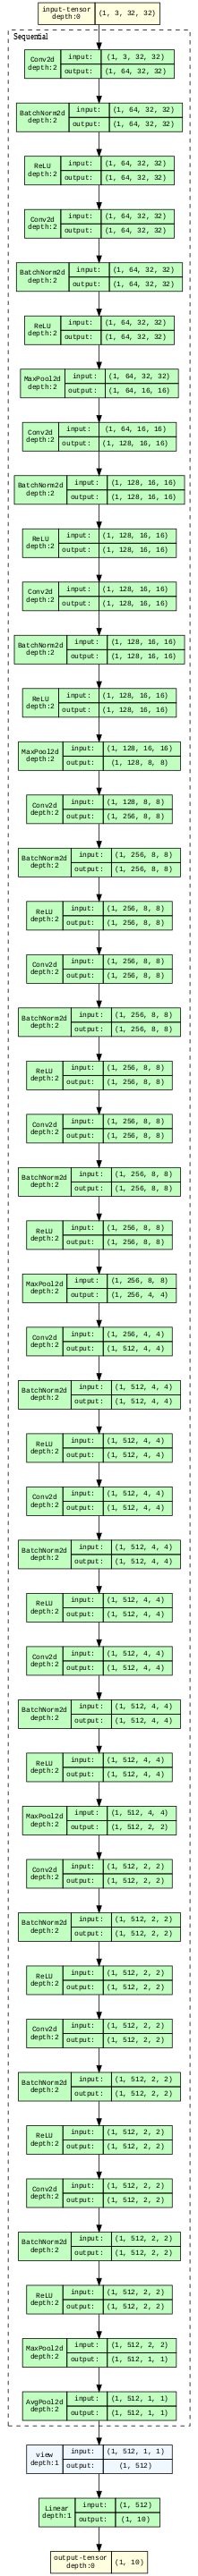

In [ ]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(vgg, input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

In [ ]:
vgg.to(device)
optimizer = torch.optim.Adam(vgg.parameters(), lr = learning_rate)

In [ ]:
train(vgg, train_data_loader, num_epochs, loss_function, optimizer, device)

Epoch[1]: Loss = 1.5713, Train accuracy = 0.3958, Time epoch = 39.8183
Epoch[2]: Loss = 1.0487, Train accuracy = 0.6215, Time epoch = 40.3721
Epoch[3]: Loss = 0.8324, Train accuracy = 0.7074, Time epoch = 39.5698
Epoch[4]: Loss = 0.7143, Train accuracy = 0.7557, Time epoch = 39.6162
Epoch[5]: Loss = 0.6160, Train accuracy = 0.7911, Time epoch = 40.1342
Epoch[6]: Loss = 0.5463, Train accuracy = 0.8147, Time epoch = 39.7500
Epoch[7]: Loss = 0.4896, Train accuracy = 0.8353, Time epoch = 40.1778
Epoch[8]: Loss = 0.4489, Train accuracy = 0.8483, Time epoch = 40.8261
Epoch[9]: Loss = 0.4105, Train accuracy = 0.8611, Time epoch = 39.1362
Epoch[10]: Loss = 0.3826, Train accuracy = 0.8734, Time epoch = 38.9897
Epoch[11]: Loss = 0.3544, Train accuracy = 0.8809, Time epoch = 39.6819
Epoch[12]: Loss = 0.3310, Train accuracy = 0.8871, Time epoch = 39.1330
Epoch[13]: Loss = 0.3009, Train accuracy = 0.8985, Time epoch = 39.5107
Epoch[14]: Loss = 0.2838, Train accuracy = 0.9044, Time epoch = 39.3139
E

In [ ]:
print('Loss = {:.4f}, Test accuracy = {:.4f}'.format(
    get_loss(vgg, test_data_loader, device),
    get_accuracy(vgg, test_data_loader, device)))

Loss = 0.0028, Test accuracy = 0.9042
